In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from src.dataset_builders import Mnist
from src.simple_cnn import SimpleCNN

BATCH_SIZE = 10
EPOCHS = 2

data = Mnist()
IMG_SHAPE = data.IMG_SHAPE
NUM_CLASSES = data.NUM_CLASSES
x_train = data.x_train
x_test = data.x_test
y_train = data.y_train
y_test = data.y_test


/Users/i862304/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(60000, 28, 28)
(10000, 28, 28)
(60000, 10)
(10000, 10)

final shape (x_train): (60000, 28, 28, 1)
final shape (x_test): (10000, 28, 28, 1)
final shape (y_train): (60000, 10)
final shape (y_test): (10000, 10)



# Train a Model

Epoch 1/2
60000/60000 [==============================] - 94s 2ms/step - loss: 0.3322 - acc: 0.8974
Epoch 2/2
60000/60000 [==============================] - 82s 1ms/step - loss: 0.1949 - acc: 0.9422


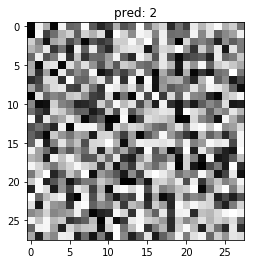

In [2]:
DIMS = [16, 16, 64]
M = SimpleCNN(IMG_SHAPE, NUM_CLASSES, dims=DIMS)
cnn = M.cnn
cnn.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

temp_x = np.random.random((1,28,28,1))
temp_pred_arr = cnn.predict(temp_x)
temp_pred = temp_pred_arr.argmax()
temp_pred

def show(img, pred):
    img = img.reshape((28, 28))
    plt.title("pred: {}".format(pred))
    plt.imshow(img, cmap='Greys')
    plt.show
    
show(temp_x, temp_pred)

In [3]:
print(tf.__version__)

1.12.0


# Save and Convert to TFlite

In [4]:
# Save tf.keras model in HDF5 format.
keras_file = "../data/keras_model.h5"
tflite_file = "../data/converted_model.tflite"

tf.keras.models.save_model(cnn, keras_file)

## Convert to TensorFlow Lite model.
## These docs describe the converter in the TensorFlow nightly release, installed using pip install tf-nightly
# converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)

## For tensorflow 1.12 it should be 
converter = tf.contrib.lite.TFLiteConverter.from_keras_model_file(keras_file)


tflite_model = converter.convert()
open(tflite_file, "wb").write(tflite_model)

INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


604548

# Check performance of saved tflite model

In [14]:
# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(model_path=tflite_file)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
# change the following line to feed into your own data.
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.05287444 0.01230805 0.07126556 0.03165751 0.07350218 0.11480799
  0.42633265 0.01499521 0.17333022 0.02892617]]


# Test the TFLite Model

In [28]:

def test_tflite_model(datum):
    """run one datapoint through tflite model
    
    Pretty sure there is a prettier/more concise way to do this
    But I'll worry about finding it later
    """
    # Load TFLite model and allocate tensors.
    interpreter = tf.contrib.lite.Interpreter(model_path=tflite_file)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data.
    input_shape = input_details[0]['shape']
    input_data = np.array(datum.reshape(input_shape))
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # print(output_data)
    return output_data

n=42
print(y_test[n].argmax())
print(test_tflite_model(x_test[n]).argmax())
print(test_tflite_model(x_test[n]).max())



4
4
0.9992206


In [47]:
## Gotta be a better way to do this too
results = np.array([test_tflite_model(xx) for xx in x_test])
results = results.reshape(10000, 10)

df = pd.DataFrame({"truth": np.argmax(y_test, axis=1),
                   "prediction": np.argmax(results, axis=1),
                   "score": np.amax(results, axis=1),                   
                  })
df.head()

,truth,prediction,score
0,7,7,0.999989
1,2,2,0.999977
2,1,1,0.999849
3,0,0,0.999861
4,4,4,0.999601
